# INF200 Lecture No 10
### 16 November 2014

## Today's topics

1. Review of EX07: Markov Chain Analysis
    - Use of colormaps
1. Linear algebra with NumPy
    - Eigenvalue analysis of Markov chains
1. Statistical analysis with SciPy
    - Testing chutes and ladders simulations against numerical results
1. Solving differential equations with SciPy
    - Planetary motion
1. Loading data from text files
    - Decimal commas and date formats
1. A very brief introduction to Pandas
1. An even shorter introduction to SymPy
1. More cool stuff
    - Seaborn
    - GlueViz
    - HoloViews
    - SymPy

## 0. Course information

- There will be no PA03
- You should explore the material presented in this lecture by working (playing) with this notebook
- There will be no computer lab on Friday 20 and Friday 27 November
- **Mandatory computer lab Friday 4 December 08.15-10.00**
    - Presentation of the January project
    - Find your project partner by then
- **Project start:** Monday, January 4, 09.00 in TF02
    - Attendance during project period is **mandatory** (Mon-Fri, 9.00-15.00)
    - Exam: **Monday, 25 Januar 2016, between 09.00 and 19.00**

## 1. Review of EX07

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

### Part A: Functions for Markov chain analysis

In [2]:
def propagator(ladders=None, chutes=None, goal=90):
    ladders = ladders if ladders is not None else [(1, 40), (8, 10), (36, 52), 
                                                   (43, 62), (49, 79), (65, 82), 
                                                   (68, 85)] 
    chutes = chutes if chutes is not None else [(24, 5), (33, 3), (42, 30), 
                                                (56, 37), (64, 27), (74, 12), 
                                                (87, 70)]
    
    M = np.zeros((goal+1, goal+1))
    M[goal, goal] = 1
    M[goal, (goal-6):goal] = np.array([1., 2., 3., 4., 5., 6.]) / 6.
    for i in range(1, goal):
        M[i, max(0, i-6):i] = 1./6.
        
    L = M.copy()
    for start, dest in chutes + ladders:
        L[start, :] = 0.
        L[dest, :] += M[start, :]
        
    return L

In [3]:
def evolve(prop, num_moves, initial=None):
    r, c = prop.shape
    assert r == c, "Propagator must be square"
    if initial is None:
        initial = np.zeros(r)
        initial[0] = 1
    else:
        assert len(initial) == r, "Initial size wrong"
    
    p = np.zeros((r, num_moves+1))
    p[:, 0] = initial
    
    for k in range(1, num_moves+1):
        p[:, k] = np.dot(prop, p[:, k-1])
        
    return p    

In [4]:
def arrival_dist(p_evol):
    Q = p_evol[-1, :]
    q = np.zeros_like(Q)
    q[1:] = np.diff(Q)
    return q, Q

### Part B: Reproducing results from the lecture using the functions from Part A

#### Run the analysis

In [5]:
prop = propagator()
p = evolve(prop, 300)
q, Q = arrival_dist(p)

#### Propagator matrix

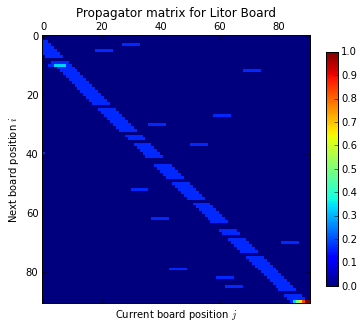

In [6]:
plt.matshow(prop)
plt.xlabel('Current board position $j$');
plt.ylabel('Next board position $i$');
plt.title('Propagator matrix for Litor Board');
plt.colorbar(shrink=0.7);

- Problems with the figure above: 
    - all values in the matrix are either 0 or a multiple of 1/6
    - this is not clear from the color scale
    - actual values are difficult to read off
    - color scale is not linear in any sense
- Solution: Alternative color map
    - See [Choosing colormaps](http://matplotlib.org/users/colormaps.html) and [Colormaps reference](http://matplotlib.org/examples/color/colormaps_reference.html)
    - See also [this presentation on the future default colormap in Matplotlib 2.0](https://bids.github.io/colormap/)
- Some of the examples below are based on ideas from
    - http://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar
    - http://pyhogs.github.io/colormap-examples.html

##### Step 1: Use a perceptually uniform color map

- Lightness changes uniformly over range of color map
- The `_r` suffix on the name reverses the color map, so that 0 is darkest
- For clarity, we use a small matrix and drop axis decorations

In [7]:
import matplotlib.cm as cm

In [8]:
propsmall = propagator(ladders=[(3, 5), (10, 15)], chutes=[(7, 2), (16, 12)], goal=20)

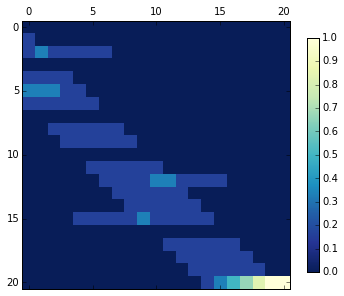

In [9]:
plt.matshow(propsmall, cmap=cm.YlGnBu_r)
plt.colorbar(shrink=0.7);

##### Step 2: Discrete color map with values 0, 1/6, 2/6, ..., 1

- Seven different colors needed
- We can just get a color map with the necessary number of levels

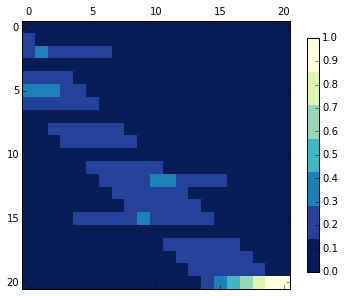

In [10]:
cm7 = cm.get_cmap('YlGnBu_r', 7)
plt.matshow(propsmall, cmap=cm7)
plt.colorbar(shrink=0.7);

- The axis label are now not very helpful
- We can change the placement of the labels

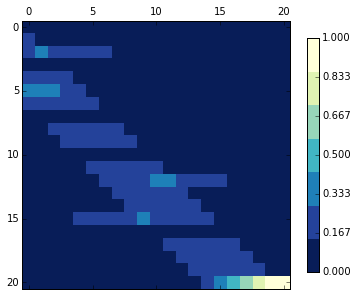

In [11]:
cm7 = cm.get_cmap('YlGnBu_r', 7)
plt.matshow(propsmall, cmap=cm7)
cax = plt.colorbar(shrink=0.7);
cax.set_ticks(np.linspace(0, 1, 7));

- Better, but it would be even nicer to place the markers in the center of the boxes and show fractions
- For $n$ boxes, the box centers are placed at

$$y_k = \frac{1}{2n} + \frac{k}{n} \quad k = 0, 1, \dots, n-1$$

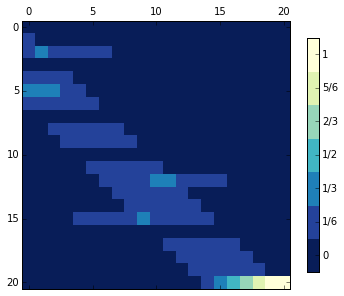

In [12]:
cm7 = cm.get_cmap('YlGnBu_r', 7)
plt.matshow(propsmall, cmap=cm7)
cax = plt.colorbar(shrink=0.7);
cax.set_ticks(np.arange(0., 7.) / 7. + 1./14.);
cax.set_ticklabels(('0', '1/6', '1/3', '1/2', '2/3', '5/6', '1'));

##### Step 3: change representation of zero probability for better contrast

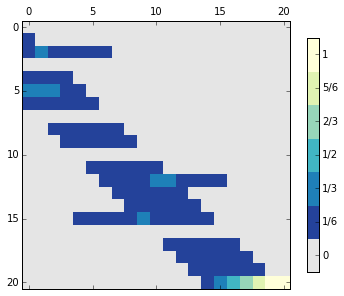

In [13]:
cm7 = cm.get_cmap('YlGnBu_r', 7)
cm7list = [cm7(i) for i in range(cm7.N)]
cm7list[0] = [0.9, 0.9, 0.9]
cm7mod = cm7.from_list('mymap', cm7list, cm7.N)
plt.matshow(propsmall, cmap=cm7mod)
cax = plt.colorbar(shrink=0.7);
cax.set_ticks(np.arange(0., 7.) / 7. + 1./14.);
cax.set_ticklabels(('0', '1/6', '1/3', '1/2', '2/3', '5/6', '1'));

#### Time evolution of residence probability

- We will use a similar color map as above for the time evolution, but with full resolution
- We will mark values below a certain limit with a separat color

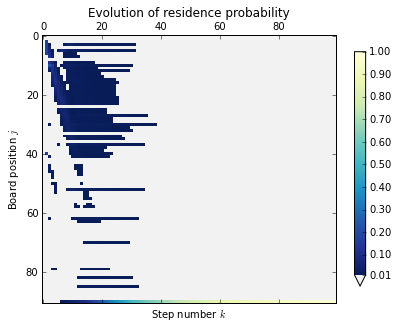

In [14]:
p_cutoff = 0.01

cm_p = cm.get_cmap('YlGnBu_r')
cm_p.set_under((0.95,0.95, 0.95))
plt.matshow(p[:, :100], cmap=cm_p, vmin=p_cutoff)
plt.xlabel('Step number $k$');
plt.ylabel('Board position $j$');
plt.title('Evolution of residence probability');
cax = plt.colorbar(shrink=0.7, extend='min');
cax.set_ticks([p_cutoff] + list(np.arange(0.1, 1.01, 0.1)));

##### Step 4: Zooming in on parts of the color scale

In [15]:
from matplotlib.colors import PowerNorm

/Users/plesser/anaconda/lib/python2.7/site-packages/matplotlib/colors.py:1178: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)
/Users/plesser/anaconda/lib/python2.7/site-packages/matplotlib/colorbar.py:588: RuntimeWarning: invalid value encountered in greater
  inrange = (ticks > -0.001) & (ticks < 1.001)
/Users/plesser/anaconda/lib/python2.7/site-packages/matplotlib/colorbar.py:588: RuntimeWarning: invalid value encountered in less
  inrange = (ticks > -0.001) & (ticks < 1.001)
/Users/plesser/anaconda/lib/python2.7/site-packages/matplotlib/colorbar.py:839: RuntimeWarning: invalid value encountered in true_divide
  z = np.take(y, i0) + (xn - np.take(b, i0)) * dy / db
/Users/plesser/anaconda/lib/python2.7/site-packages/matplotlib/colors.py:584: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


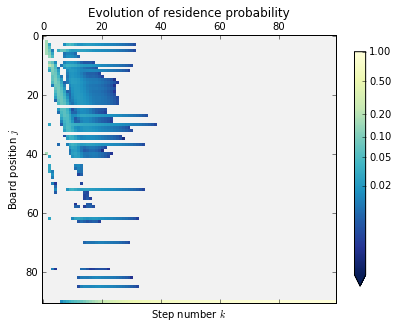

In [16]:
p_cutoff = 0.01

cm_p = cm.get_cmap('YlGnBu_r')
cm_p.set_under((0.95,0.95, 0.95))
plt.matshow(p[:, :100], cmap=cm_p, vmin=p_cutoff,
           norm=PowerNorm(gamma=0.2, vmin=p_cutoff, vmax=1))
plt.xlabel('Step number $k$');
plt.ylabel('Board position $j$');
plt.title('Evolution of residence probability');
cax = plt.colorbar(shrink=0.7, extend='min');
cax.set_ticks([p_cutoff, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]);

- Note that the arrow now is not filled gray and that the 0.01 tick mark is not shown.
- This appears to be a bug.

#### Arrival time distribution

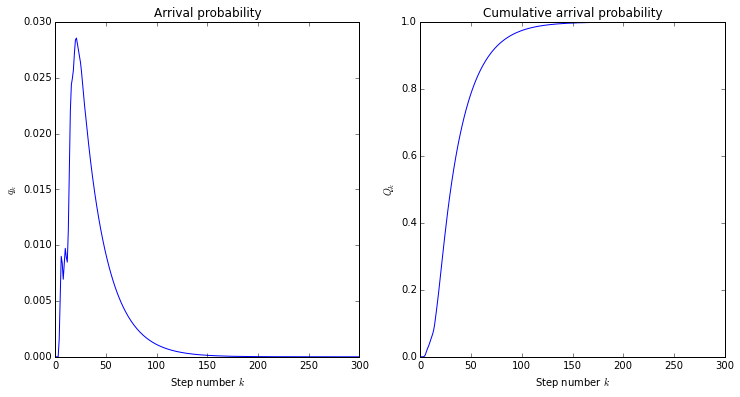

In [17]:
plt.subplot(1, 2, 1)
plt.plot(q)
plt.xlabel('Step number $k$')
plt.ylabel('$q_k$')
plt.title('Arrival probability')

plt.subplot(1, 2, 2)
plt.plot(Q)
plt.xlabel('Step number $k$')
plt.ylabel('$Q_k$')
plt.title('Cumulative arrival probability');

#### Residence probabilities after different numbers of moves

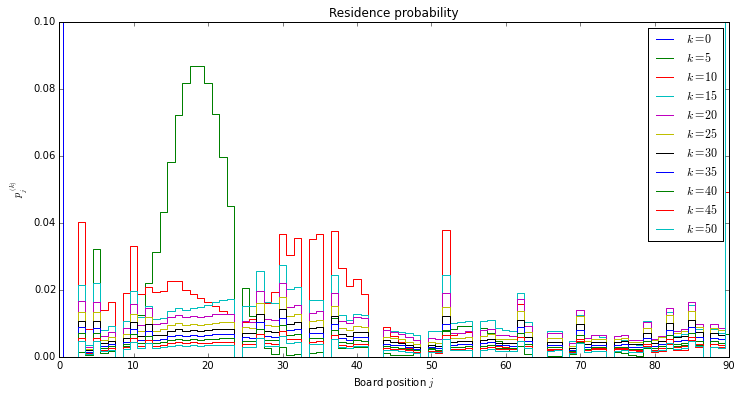

In [18]:
for k in range(0, 51, 5):
    plt.step(range(p.shape[0]), p[:, k], label='$k = {}$'.format(k),
            where='mid')
plt.ylim(0, 0.1)
plt.legend()
plt.xlabel('Board position $j$')
plt.ylabel('$p_j^{(k)}$')
plt.title('Residence probability');

### Part C: Visual comparison with simulation results

In [19]:
import sys
sys.path.insert(0, '../../Exercises/ex07')
from chutes_simulation import Simulation, Player

In [20]:
sim = Simulation([Player])
sim.run_simulation(10000)
durations = sim.durations_per_type()[Player]

In [21]:
def sim_distribution(dur):
    qE = np.zeros(max(dur)+1, dtype=float)
    for n in frozenset(dur):
        qE[n] = dur.count(n)
    qE /= len(dur)
    return qE

In [22]:
q_sim = sim_distribution(durations)

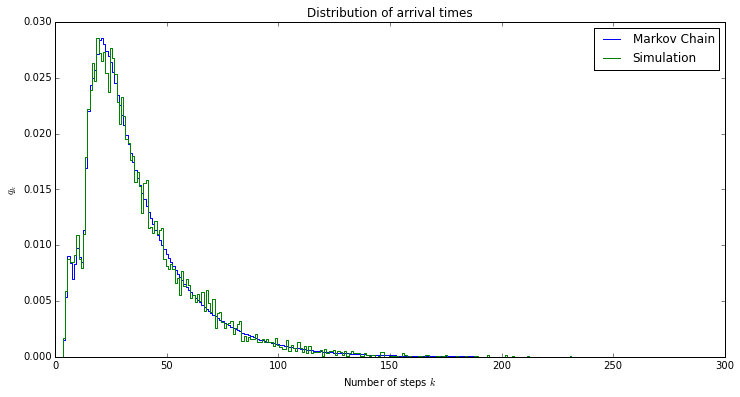

In [23]:
plt.step(range(len(q)), q, where='mid', label='Markov Chain');
plt.step(range(len(q_sim)), q_sim, where='mid', label='Simulation');
plt.title('Distribution of arrival times')
plt.xlabel('Number of steps $k$');
plt.ylabel('$q_k$');
plt.legend();

### Part D: Variants of the board

#### Variant 1: No ladders

In [24]:
prop_nl = propagator(ladders=[])
p_nl = evolve(prop_nl, 300)
q_nl, Q_nl = arrival_dist(p_nl)

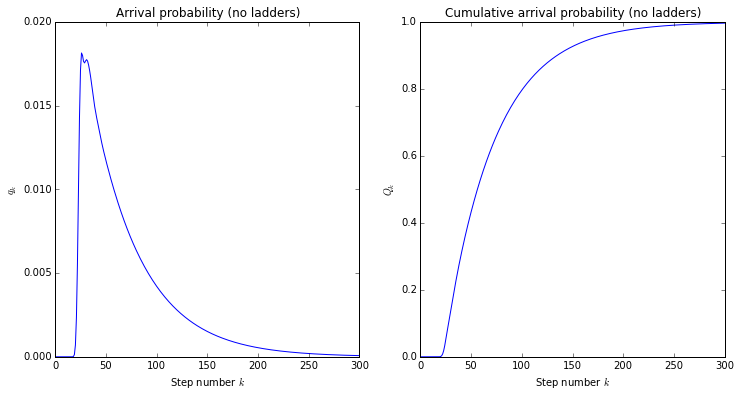

In [25]:
plt.subplot(1, 2, 1)
plt.plot(q_nl)
plt.xlabel('Step number $k$')
plt.ylabel('$q_k$')
plt.title('Arrival probability (no ladders)')

plt.subplot(1, 2, 2)
plt.plot(Q_nl)
plt.xlabel('Step number $k$')
plt.ylabel('$Q_k$')
plt.title('Cumulative arrival probability (no ladders)');

#### Variant 2: no chutes

In [26]:
prop_nc = propagator(chutes=[])
p_nc = evolve(prop_nc, 300)
q_nc, Q_nc = arrival_dist(p_nc)

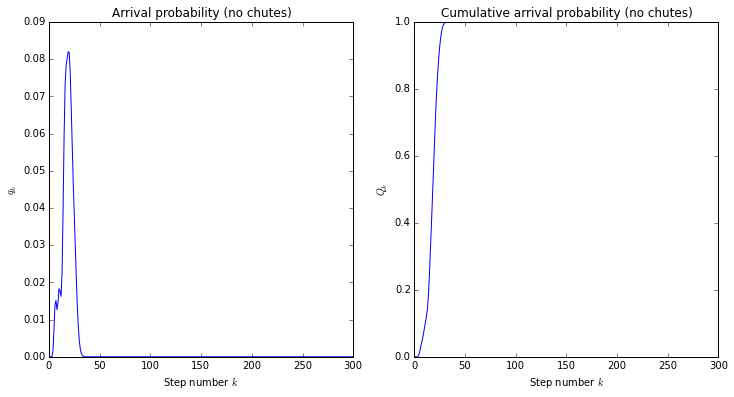

In [27]:
plt.subplot(1, 2, 1)
plt.plot(q_nc)
plt.xlabel('Step number $k$')
plt.ylabel('$q_k$')
plt.title('Arrival probability (no chutes)')

plt.subplot(1, 2, 2)
plt.plot(Q_nc)
plt.xlabel('Step number $k$')
plt.ylabel('$Q_k$')
plt.title('Cumulative arrival probability (no chutes)');

### Comparison of the three variants

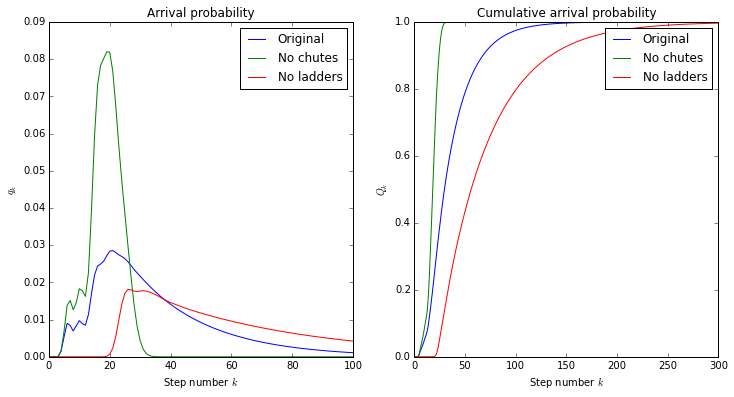

In [28]:
plt.subplot(1, 2, 1)
plt.plot(q, label='Original')
plt.plot(q_nc, label='No chutes')
plt.plot(q_nl, label='No ladders')
plt.xlim(0, 100)
plt.xlabel('Step number $k$')
plt.ylabel('$q_k$')
plt.title('Arrival probability')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Q, label='Original')
plt.plot(Q_nc, label='No chutes')
plt.plot(Q_nl, label='No ladders')
plt.xlabel('Step number $k$')
plt.ylabel('$Q_k$')
plt.title('Cumulative arrival probability')
plt.legend();

### Part E: Different rules for reaching the goal

#### Reach goal exactly

We need to modify matrix $M$ for the base case as follows:

$$M_{ij} = 1/6 \quad\mathrm{for}\; j+1\leq i \leq j+6 \;\mathrm{and}\; i \le G$$

now also holds for the $i=G$, i.e., the goal line. In addition, we get the following rule expressing that the player does not move when it would move past the goal:

$$M_{jj} = 1-\frac{G-j}{6} \quad\mathrm{for}\; G-6 < j < G\;.$$

In [29]:
def propagator_exact(ladders=None, chutes=None, goal=90):
    ladders = ladders if ladders is not None else [(1, 40), (8, 10), (36, 52), 
                                                   (43, 62), (49, 79), (65, 82), 
                                                   (68, 85)] 
    chutes = chutes if chutes is not None else [(24, 5), (33, 3), (42, 30), 
                                                (56, 37), (64, 27), (74, 12), 
                                                (87, 70)]
    
    M = np.zeros((goal+1, goal+1))
    M[goal, goal] = 1
    for i in range(1, goal+1):
        M[i, max(0, i-6):i] = 1./6.
    for j in range(goal-5, goal):
        M[j, j] = 1 - float(goal-j) / 6.0
        
    L = M.copy()
    for start, dest in chutes + ladders:
        L[start, :] = 0.
        L[dest, :] += M[start, :]
        
    return L

#### Test without ladders or chutes

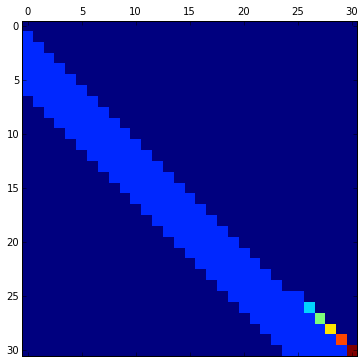

In [30]:
pr_e_test = propagator_exact(ladders=[], chutes=[], goal=30)
plt.matshow(pr_e_test);

Looks ok.

#### Create matrix for Litor board and evolve

In [31]:
prop_e = propagator_exact()
p_e = evolve(prop_e, 300)
q_e, Q_e = arrival_dist(p_e)

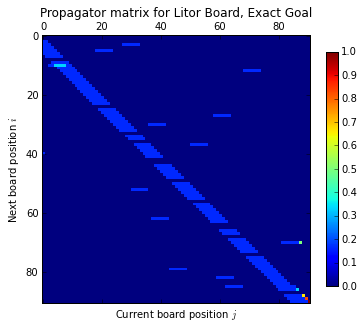

In [32]:
plt.matshow(prop_e)
plt.xlabel('Current board position $j$');
plt.ylabel('Next board position $i$');
plt.title('Propagator matrix for Litor Board, Exact Goal');
ax = plt.colorbar(shrink=0.7);

#### Bounce back if trying to pass goal

In this case, we need to modify the base matrix $M$ as follows:

The general case now only applies for $j\leq G-6$ and is best expressed in terms of $j$

$$M_{ij} = 1/6 \quad\mathrm{for}\; j+1\leq i \leq j+6 \;\mathrm{and}\; j \le G-6$$

For the last columns towards the goal, probablities are a bit difficult to write down with a general equation, but we can write them down explicity:

$$
\begin{array}{r|rrrrrr}
i,j & G-5 & G-4 & G-3 & G-2 & G-1 & G \\\hline
G-5 &   0 & 0  & 0  & 0  & 1/6& 0\\
G-4 & 1/6 & 0  & 0  & 1/6& 1/6& 0\\
G-3 & 1/6 & 1/6& 1/6& 1/6& 1/6& 0\\
G-2 & 1/6 & 1/3& 1/3& 1/6& 1/6& 0\\
G-1 & 1/3 & 1/3& 1/3& 1/3& 1/6& 0\\
G & 1/6 & 1/6& 1/6& 1/6& 1/6& 1\\
\end{array}
$$

In [33]:
def propagator_reflect(ladders=None, chutes=None, goal=90):
    ladders = ladders if ladders is not None else [(1, 40), (8, 10), (36, 52), 
                                                   (43, 62), (49, 79), (65, 82), 
                                                   (68, 85)] 
    chutes = chutes if chutes is not None else [(24, 5), (33, 3), (42, 30), 
                                                (56, 37), (64, 27), (74, 12), 
                                                (87, 70)]
    
    M = np.zeros((goal+1, goal+1))
    for j in range(0, goal-5):
        M[(j+1):(j+7), j] = 1./6.
    M[goal-5, (goal-5):] = np.array([0., 0., 0., 0., 1., 0.]) / 6.
    M[goal-4, (goal-5):] = np.array([1., 0., 0., 1., 1., 0.]) / 6.
    M[goal-3, (goal-5):] = np.array([1., 1., 1., 1., 1., 0.]) / 6.
    M[goal-2, (goal-5):] = np.array([1., 2., 2., 1., 1., 0.]) / 6.
    M[goal-1, (goal-5):] = np.array([2., 2., 2., 2., 1., 0.]) / 6.
    M[goal  , (goal-5):] = np.array([1., 1., 1., 1., 1., 6.]) / 6.

    L = M.copy()
    for start, dest in chutes + ladders:
        L[start, :] = 0.
        L[dest, :] += M[start, :]
        
    return L

#### Test without ladders and chutes

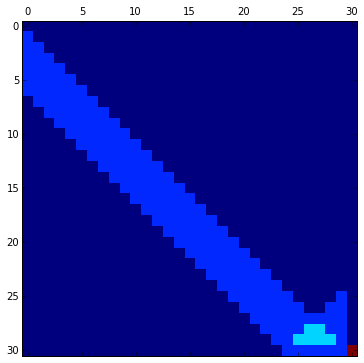

In [34]:
pr_r_test = propagator_reflect(ladders=[], chutes=[], goal=30)
plt.matshow(pr_r_test);

Verified by manual comparison with board.

### Create matrix for Litor board and evolve

In [35]:
prop_r = propagator_reflect()
p_r = evolve(prop_r, 300)
q_r, Q_r = arrival_dist(p_r)

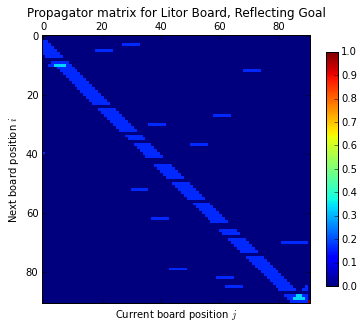

In [36]:
plt.matshow(prop_r)
plt.xlabel('Current board position $j$');
plt.ylabel('Next board position $i$');
plt.title('Propagator matrix for Litor Board, Reflecting Goal');
ax = plt.colorbar(shrink=0.7);

#### Compare effects of different types of goals

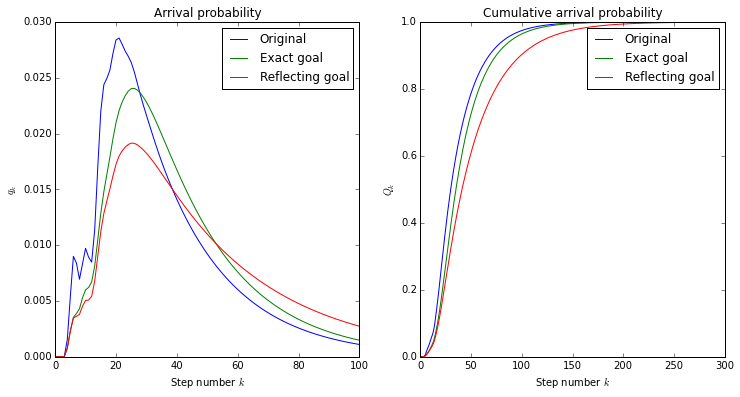

In [37]:
plt.subplot(1, 2, 1)
plt.plot(q, label='Original')
plt.plot(q_e, label='Exact goal')
plt.plot(q_r, label='Reflecting goal')
plt.xlim(0, 100)
plt.xlabel('Step number $k$')
plt.ylabel('$q_k$')
plt.title('Arrival probability')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Q, label='Original')
plt.plot(Q_e, label='Exact goal')
plt.plot(Q_r, label='Reflecting goal')
plt.xlabel('Step number $k$')
plt.ylabel('$Q_k$')
plt.title('Cumulative arrival probability')
plt.legend();

## 2. Linear algebra with NumPy: A Circular Chutes & Ladders

We now consider a circular world: any walker passing the goal re-enters the world at 0. For the base matrix $M$, this means that

$$M_{ij} = 1/6 \quad\mathrm{for}\; j+1\bmod G\leq i \leq j+6\bmod G \;\forall\; j$$

In [38]:
def propagator_circular(ladders=None, chutes=None, goal=90):
    ladders = ladders if ladders is not None else [(1, 40), (8, 10), (36, 52), 
                                                   (43, 62), (49, 79), (65, 82), 
                                                   (68, 85)] 
    chutes = chutes if chutes is not None else [(24, 5), (33, 3), (42, 30), 
                                                (56, 37), (64, 27), (74, 12), 
                                                (87, 70)]
    
    M = np.zeros((goal+1, goal+1))
    for j in range(0, goal-5):
        M[(j+1):(j+7), j] = 1./6.
    for j in range(goal-5, goal+1):
        M[(j+1):, j] = 1./6.
        M[:(6+j-goal), j] = 1./6.
        
    L = M.copy()
    for start, dest in chutes + ladders:
        L[start, :] = 0.
        L[dest, :] += M[start, :]
        
    return L

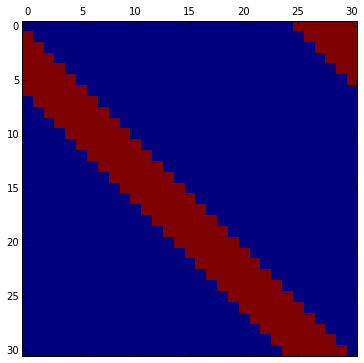

In [39]:
pr_c_test = propagator_circular(ladders=[], chutes=[], goal=30)
plt.matshow(pr_c_test);

### Evolution in circular world with chutes and ladders

- Since the world has no structure, we expect a uniform distribution in the long run
- Since the world has 31 places, the probability to be in any one place is expected to be $1/31$
- It makes no sense to look at $q$ and $Q$, the interesting quantity is $p_n^{(k)}$ for $k\to\infty$.

In [40]:
p_c_test = evolve(pr_c_test, 100)

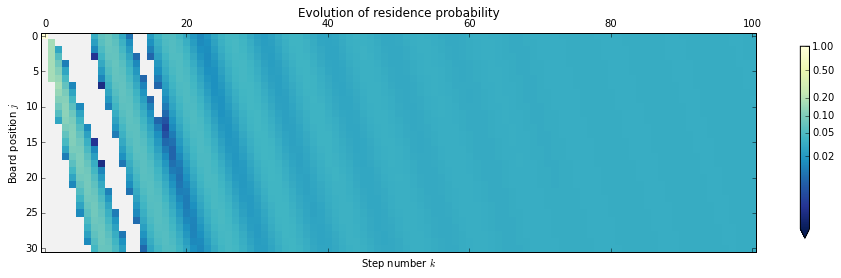

In [41]:
p_cutoff = 0.01

cm_p = cm.get_cmap('YlGnBu_r')
cm_p.set_under((0.95,0.95, 0.95))
plt.matshow(p_c_test, cmap=cm_p, vmin=p_cutoff,
           norm=PowerNorm(gamma=0.2, vmin=p_cutoff, vmax=1))
plt.xlabel('Step number $k$');
plt.ylabel('Board position $j$');
plt.title('Evolution of residence probability');
cax = plt.colorbar(shrink=0.7, extend='min');
cax.set_ticks([p_cutoff, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]);

- We see the players rotate around the world and smooth out.
- Let's look at distributions at different times

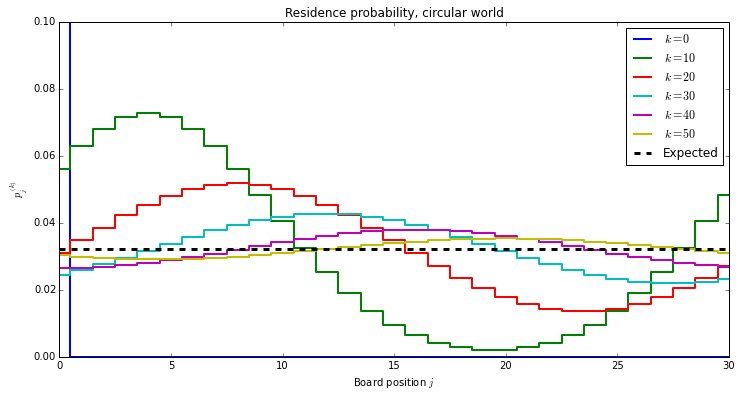

In [42]:
size = p_c_test.shape[0]
for k in range(0, 51, 10):
    plt.step(range(size), p_c_test[:, k], 
             label='$k = {}$'.format(k),
             where='mid', lw=2)
plt.plot([0, size-1], [1./size, 1./size], 'k--', label='Expected', lw=3)
plt.ylim(0, 0.1)
plt.legend()
plt.xlabel('Board position $j$')
plt.ylabel('$p_j^{(k)}$')
plt.title('Residence probability, circular world');

- Looks like nice convergence towards expectation.

### Now with chutes and ladders

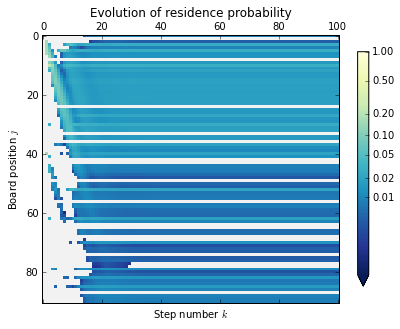

In [43]:
pr_c = propagator_circular()
p_c = evolve(pr_c, 100)

p_cutoff=0.005
plt.matshow(p_c, cmap=cm_p, vmin=p_cutoff,
           norm=PowerNorm(gamma=0.2, vmin=p_cutoff, vmax=1))
plt.xlabel('Step number $k$');
plt.ylabel('Board position $j$');
plt.title('Evolution of residence probability');
cax = plt.colorbar(shrink=0.7, extend='min');
cax.set_ticks([p_cutoff, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]);

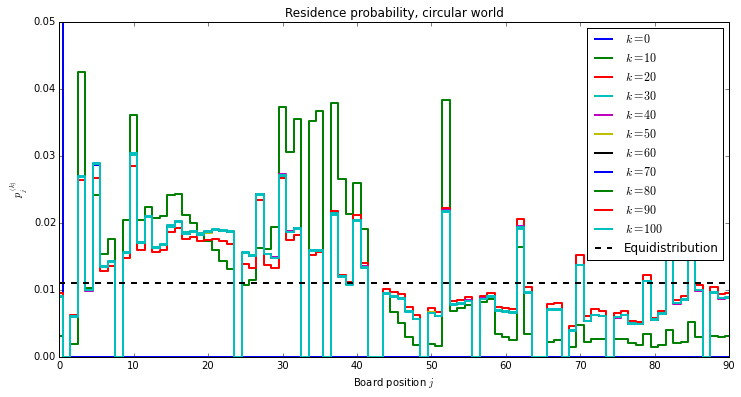

In [44]:
size = p_c.shape[0]
for k in range(0, 101, 10):
    plt.step(range(size), p_c[:, k], 
             label='$k = {}$'.format(k),
             where='mid', lw=2)
plt.plot([0, size-1], [1./size, 1./size], 'k--', label='Equidistribution', lw=2)
plt.ylim(0, 0.05)
plt.legend()
plt.xlabel('Board position $j$')
plt.ylabel('$p_j^{(k)}$')
plt.title('Residence probability, circular world');

- We see a clear structure in the distribution, it is not evenly distributed.
- As a consistency check, residence probability should be zero at the top of chutes and bottom of ladders.
- We also see clear convergence, after 20 steps the distribution is already very close to $p_n^{(100)}$.

### Eigenvector analysis

- The steady state is given by $p^{(\infty)} = L \times p^{(\infty)} $
- I.e., it is the eigenvector to eigenvalue 1 of the propagator matrix

In [45]:
ew, ev = np.linalg.eig(pr_c)

In [46]:
max(np.abs(ew))

1.0000000000000013

- The largest eigenvalue is 1, this means all other eigenmodes will decay
- Let's look at all of them, sorted

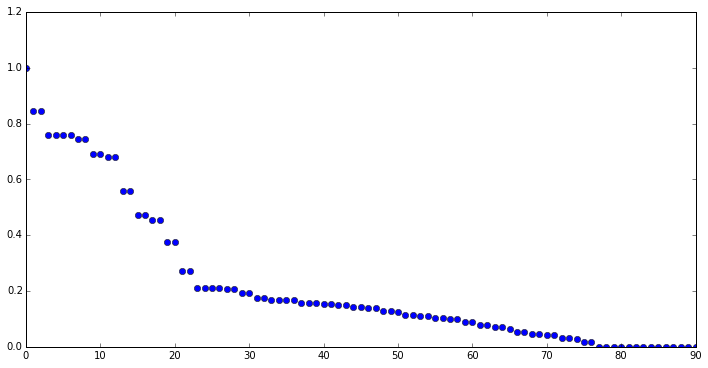

In [47]:
plt.plot(sorted(np.abs(ew), reverse=True), 'o');

- The eigenvalues except for the first appear in pairs, this is to be expected for complex eigenvalues
- Just check that the first eigenvalue is the one with value 1

In [48]:
print ew[:5]

[ 1.00000000+0.j          0.82232039+0.19094775j  0.82232039-0.19094775j
  0.55126006+0.52110569j  0.55126006-0.52110569j]


- Okay, then the stationary distribution is the corresponding eigenvector
- The eigenvector must be real, but we must force it explicitly to real (ie float type) to avoid plotting problems
- We must also normalize the eigenvector to a probablity distribution

In [49]:
p_c_inf = ev[:, 0].real / ev[:, 0].real.sum()

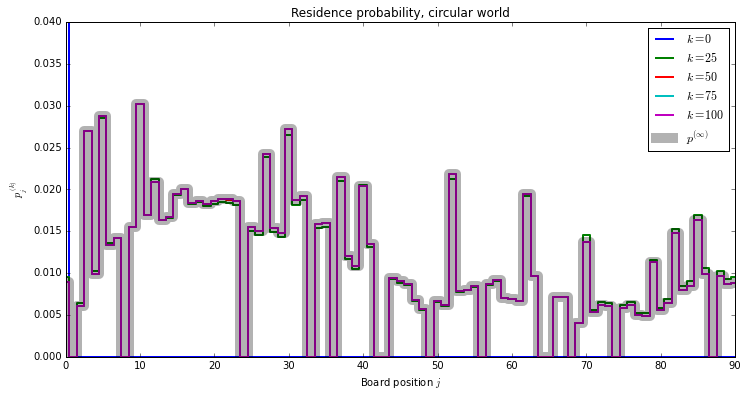

In [50]:
size = p_c.shape[0]
for k in range(0, 101, 25):
    plt.step(range(size), p_c[:, k], 
             label='$k = {}$'.format(k),
             where='mid', lw=2)
plt.step(range(size), p_c_inf, label=r'$p^{(\infty)}$', where='mid',
        lw=10, alpha=.3, color='k')
plt.ylim(0, 0.04)
plt.legend()
plt.xlabel('Board position $j$')
plt.ylabel('$p_j^{(k)}$')
plt.title('Residence probability, circular world');

- We see that the distribution obtained by evolving the probability by repeated multiplication with the propagator matrix agrees very well with the result of the eigenvector analysis.

## 3. Statistical analysis with SciPy

- [SciPy Stats](http://docs.scipy.org/doc/scipy/reference/stats.html) offers a wide range of probability distributinos and statistical tests
- Even more are available through the [RPy2](https://pypi.python.org/pypi/rpy2) package making R available in Python 

### Testing different Walker types for equal means

- We would like to know if LazyPlayer and ResilientPlayer have different mean game durations than Player
- We generate sample game durations using our simulation code
- We then test for equality of mean using [Welch's t-test](https://en.wikipedia.org/wiki/Welch%27s_t_test)
- We need to use Welch's test (instead of Student's) because the distributions of game durations may have different variances for different player types

In [51]:
from chutes_simulation import LazyPlayer, ResilientPlayer

#### Simulations

In [52]:
durations = {}
for idx, pt in enumerate([Player, LazyPlayer, ResilientPlayer]):
    sim = Simulation([pt], seed=1234567+idx)
    sim.run_simulation(1000)
    durations[pt] = sim.durations_per_type()[pt]

#### Basic statistics

In [53]:
stats = {pt: (np.mean(dur), np.std(dur)) for pt, dur in durations.items()}
stats

{chutes_simulation.LazyPlayer: (38.954999999999998, 24.965996375069835),
 chutes_simulation.ResilientPlayer: (35.850999999999999, 21.072845061832538),
 chutes_simulation.Player: (36.261000000000003, 23.688285691455178)}

#### Statistical tests

In [54]:
import scipy.stats as stats

In [55]:
stats.ttest_ind(durations[Player], durations[LazyPlayer], equal_var=False)

(-2.4741416641174512, 0.013438414812814664)

In [56]:
stats.ttest_ind(durations[Player], durations[ResilientPlayer], equal_var=False)

(0.40873368471932364, 0.68277950874838089)

In [57]:
stats.ttest_ind(durations[LazyPlayer], durations[ResilientPlayer], equal_var=False)

(3.0029480586584807, 0.0027078981451910391)

- The results are the value of the $t$ statistic and the $p$-value
- Lazy and resilient player have $p<0.005$, so the difference between their means is highly significant
- The $p$-value returned by the comparision of player and resilient player indicates no significant difference
- The comparison of player and lazy player is $p\approx 0.01$, so the difference is statistically significant

We run again with more repetitions and see how that affects the statistical significance:

In [58]:
durations = {}
for idx, pt in enumerate([Player, LazyPlayer, ResilientPlayer]):
    sim = Simulation([pt], seed=1234567+idx)
    sim.run_simulation(10000)
    durations[pt] = sim.durations_per_type()[pt]

print 'Player-LazyPlayer:', stats.ttest_ind(durations[Player], durations[LazyPlayer], equal_var=False)
print 'Player-ResilientPlayer:', stats.ttest_ind(durations[Player], durations[ResilientPlayer], equal_var=False)
print 'LazyPlayer-ResilientPlayer:', stats.ttest_ind(durations[LazyPlayer], durations[ResilientPlayer], equal_var=False)

Player-LazyPlayer: (-5.7855674514016497, 7.3348953464992696e-09)
Player-ResilientPlayer: (5.4330269060477798, 5.6058452342065789e-08)
LazyPlayer-ResilientPlayer: (11.329783943996674, 1.1551460000034931e-29)


- Results now show highly significant differences for all comparisons.

## 4. Solving differential equations with SciPy

- Simulate a three-body problem of "planets" moving according to Newton's laws
- For simplicity, we let the bodies move in the plane
- Each body is described completely by 
    - its mass $m_j$
    - its position $\vec{r}_j = (x_j, y_j)$
    - its velocity $\vec{v}_j = (v_{x, j}, v_{y, j})$
- The total force acting on each body is given by
$$
\vec{F}_j = -\Gamma \sum_{k\neq j} m_j \times m_k \times \frac{\vec{r}_j-\vec{r}_k}{\left|\vec{r}_j-\vec{r}_k\right|^3}
$$
- The acceleration of a body is given by
$$
\vec{a}_j = \frac{\vec{F}_j}{m_j}
$$
- The change in position and velocity is given by
\begin{align}
\dot{\vec{v}}_ j &= \vec{a}_j \\
\dot{\vec{r}}_ j &= \vec{v}_j 
\end{align}

#### Implementation considerations

- SciPy supports integration of ODEs of the form
$$
\vec{y}'(t) = f(\vec{y}, t; parameters)
$$
- $\vec{y}$ is the *state vector* describing the system
- We need to combine all positions and velocities into one vector $\vec{y}$
- Example: three bodies, two dimensions
    - six coordinates (x and y for each of three bodies)
    - six velocity components
    - $\vec{y}$ has 12 dimensions

In [59]:
import scipy

#### Function computing the derivative

- Form of function prescribed by [scipy.integrate.odeint](http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.integrate.odeint.html)
- Set gravitational constant to 1 for convenience

In [60]:
GAMMA = 1    # gravitational constant

def f(y, t, masses):
    n_bodies = len(masses)
    n_coords = len(y) / 2
    n_dim = n_coords / n_bodies
    
    dy = np.zeros_like(y)
    dy[:n_coords] = y[n_coords:]   # velocities: r' = v
    
    r = y[:n_coords].reshape(n_bodies, n_dim) # positions
    a = np.zeros_like(r)   # accelerations
    for body in range(n_bodies):
        for other_body in range(n_bodies):
            if other_body == body:
                continue
            d = r[other_body] - r[body]
            a[body,:] += (GAMMA * masses[other_body]
                          * d * np.dot(d, d)**(-1.5))
    
    dy[n_coords:] = a.reshape(n_coords)   # accelerations: v' = a
    
    return dy

#### Euler integration

- Simplest ODE integration scheme
- Time discretized as $t_k = k \Delta t$
- Update rule
$$
\vec{y}_{k+1} = \vec{y}_k + \Delta t f(\vec{y}_k, t_k)
$$
- The function integrates the ODE from the given initial positions until tmax with time steps dt
- We assume initial velocities zero
- Returns three arrays:
    - positions `r[body, dim, time]`
    - velocities `v[body, dim, time]`
    - time

In [61]:
def planets_euler(masses, r0, dt, tmax):
    n_bodies, n_dim = r0.shape
    n_coords = n_bodies * n_dim

    t = np.arange(0., tmax, dt)
    npoints = len(t)

    y = np.zeros((npoints, 2*n_coords))
    y[0, :n_coords] = r0.reshape(n_coords)
    for n in range(npoints-1):
        y[n+1, :] = y[n, :] + dt * f(y[n, :], n*dt, masses)
        
    r = y[:, :n_coords].T.reshape((n_bodies, n_dim, -1))
    v = y[:, n_coords:].T.reshape((n_bodies, n_dim, -1))
    
    return r, v, t

#### Integration using `odeint` from `scipy.integrate`

- Uses advance ODE integration function
- Takes same input and returns same output as `planets_euler`

In [62]:
def planets_odeint(masses, r0, dt, tmax):
    n_bodies, n_dim = r0.shape
    n_coords = n_bodies * n_dim

    t = np.arange(0., tmax, dt)
    npoints = len(t)

    y0 = np.zeros(2 * n_coords)
    y0[:n_coords] = r0.reshape(n_coords)
    y = scipy.integrate.odeint(f, y0, t, (masses,))
        
    r = y[:, :n_coords].T.reshape((n_bodies, n_dim, -1))
    v = y[:, n_coords:].T.reshape((n_bodies, n_dim, -1))
    
    return r, v, t

#### Simulate example system

- Three bodies in 2-dimensional space

In [63]:
masses = np.array([5., 3., 4.])
r0 = np.array([[1., -1.], [1., 3.], [-2., -1.]])
re, ve, te = planets_euler(masses, r0, 0.001, 10)
ro, vo, to = planets_odeint(masses, r0, 0.001, 10)

#### Plot motions in plane

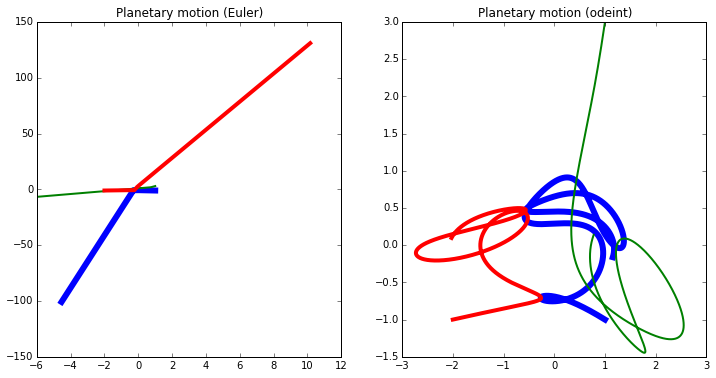

In [64]:
plt.subplot(1, 2, 1)
for ix, m in enumerate(masses):
    plt.plot(re[ix, 0,:], re[ix, 1, :], lw=2*(m-2))
plt.title('Planetary motion (Euler)')

plt.subplot(1, 2, 2)
for ix, m in enumerate(masses):
    plt.plot(ro[ix, 0,:], ro[ix, 1, :], lw=2*(m-2))
plt.title('Planetary motion (odeint)');

- Signficantly different
- Which one is correct?

#### Calculation of total energy in systems

In [65]:
def total_energy(r, v, masses):
    n_bodies, n_dim, n_t = r.shape
    energy = np.zeros(n_t)
    
    for n in range(n_t):
        for body in range(n_bodies):
            energy[n] = (0.5 * masses[body] 
                         * np.dot(v[body, :, n], v[body, :, n]))

            for other_body in range(n_bodies):
                if other_body == body:
                    continue
                d = r[other_body, :, n] - r[body, : , n]
                energy[n] += (GAMMA * masses[body] * masses[other_body]
                              * np.dot(d, d)**(-0.5))
    
    return energy

In [66]:
energy_e = total_energy(re, ve, masses)
energy_o = total_energy(ro, vo, masses)

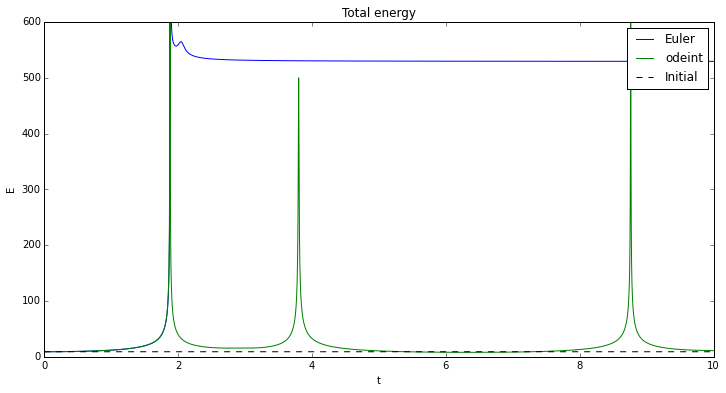

In [67]:
plt.plot(te, energy_e, label='Euler')
plt.plot(to, energy_o, label='odeint')
plt.plot(to, energy_o[0]*np.ones_like(to), 'k--', label='Initial')
plt.legend()
plt.title('Total energy')
plt.xlabel('t')
plt.ylabel('E')
plt.ylim(0, 600);

- Euler is definitely wrong
- Odeint also shows deviations, but relaxes to values much closer to the initial energy
- Odeint solution is graphically consistent with textbook solutions (Gruntz & Waldvogel in Gander & Hřebíček (eds) Problem Solving problems in scientific computing using Maple and MATLAB, Springer-Verlag, 2004, pp 51-72)

## 5. Loading data from text files

- We will explore some methods for and pitfalls related to loading data from text files
- We mainly use NumPy function [numpy.loadtxt()](http://docs.scipy.org/doc/numpy/reference/generated/numpy.loadtxt.html)
- A more powerful alternative is [numpy.genfromtxt()](http://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html)
- As example file, we use hourly metorological data from NMBUs climatological station from 1. January 2008 to early september 2008.
- The first few lines of the file look like this:
```
DATO;LT;LTmin;LTmax;RF;LP;NB1;VH;VHmax;VR;FLUXM;JT2;JT5;JT10;JT20;JT50;JT100;GLOB;DIFF;UV;Bal;Bl;Gr;R¿;Ir;PAR;Alb;GrMin
01/01/08 0:10;-2,5;-2,5;-2,4;77,4;1021,8;0,0;4,5;4,8;N;-0,5;-0,1;0,0;0,2;0,5;2,2;3,2;;;;-182,47;;;;;;;-2,99
01/01/08 1:10;-2,3;-2,4;-2,2;77,4;1022,1;0,0;4,2;4,7;N;-0,6;-0,1;0,0;0,2;0,5;2,1;3,2;;;;-183,05;;;;;;;-2,86
```
- We will limit ourselves here to the date (column 0) and temperature data (columns 1-3, 11-16 and 27)
- We notice the following from the file:
    - The first row contains headers, new need to skip it
    - Fields are separated by semicolons

#### First attempt

In [68]:
try:
    data = np.loadtxt('Data/TIME2008.csv', 
                      skiprows=1,
                      delimiter=';',
                      usecols=[0, 1, 2, 3, 11, 12, 13, 14, 15, 16, 27])
except ValueError as e:
    print "Loading failed:", e

Loading failed: invalid literal for float(): 01/01/08 0:10


#### Second attempt: date conversion

- First attempt failed because the date is not a float
- We need to specify a date converter for column 0

In [69]:
from matplotlib.dates import datestr2num

In [70]:
try:
    data = np.loadtxt('Data/TIME2008.csv', 
                      skiprows=1,
                      delimiter=';',
                      converters={0: datestr2num},
                      usecols=[0, 1, 2, 3, 11, 12, 13, 14, 15, 16, 27])
except ValueError as e:
    print "Loading failed:", e

Loading failed: invalid literal for float(): -2,5


#### Third attempt: convert European decimals
- The second attempt failed because the files contains European decimals with comma
- We need to replace each comma with a dot and then convert to float
- The following solution is based on http://www.python-forum.de/viewtopic.php?t=19732

In [71]:
def continental_decimal_to_float(s):
    try:
        return float(s.replace(',', '.'))
    except ValueError:
        return s

temp_columns = [1, 2, 3, 11, 12, 13, 14, 15, 16, 27]
converters = {tc: continental_decimal_to_float for tc in temp_columns}
converters[0] = datestr2num

try:
    data = np.loadtxt('Data/TIME2008.csv', 
                      skiprows=1,
                      delimiter=';',
                      converters=converters,
                      usecols=[0] + temp_columns)
except ValueError as e:
    print "Loading failed:", e

- Finally, it worked!
- We can plot hourly temperatures against dates

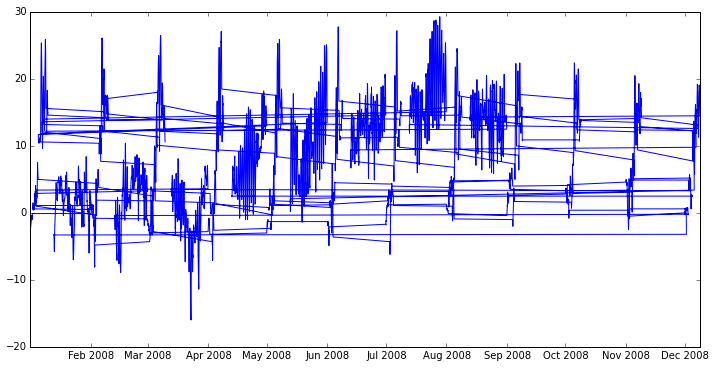

In [72]:
plt.plot_date(data[:,0], data[:,1], '-');

- This looks *very* weired
- Let us plot just the dates

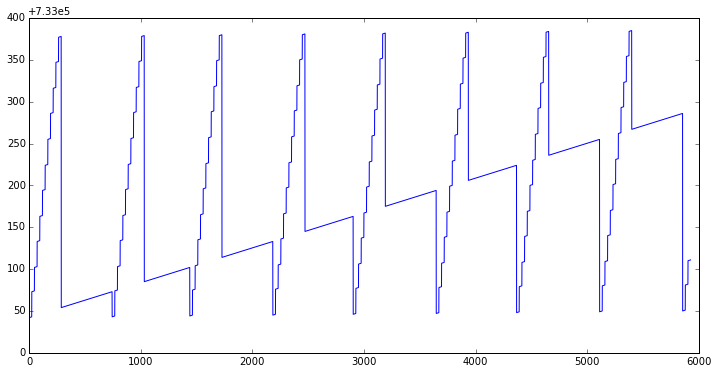

In [73]:
plt.plot(data[:, 0], '-');

#### Fourth attempt

- The previous attempt failed because `datestr2num` interpretes dates American-style where possible.
- We need a different converter that allows us to specify the date format explicitly
- This is based on http://matplotlib.1069221.n5.nabble.com/datestr2num-for-day-month-year-td43304.html

In [74]:
from matplotlib.dates import strpdate2num

In [75]:
temp_columns = [1, 2, 3, 11, 12, 13, 14, 15, 16, 27]
converters = {tc: continental_decimal_to_float for tc in temp_columns}
converters[0] = strpdate2num('%d/%m/%y %H:%M')

try:
    data = np.loadtxt('Data/TIME2008.csv', 
                      skiprows=1,
                      delimiter=';',
                      converters=converters,
                      usecols=[0] + temp_columns)
except ValueError as e:
    print "Loading failed:", e

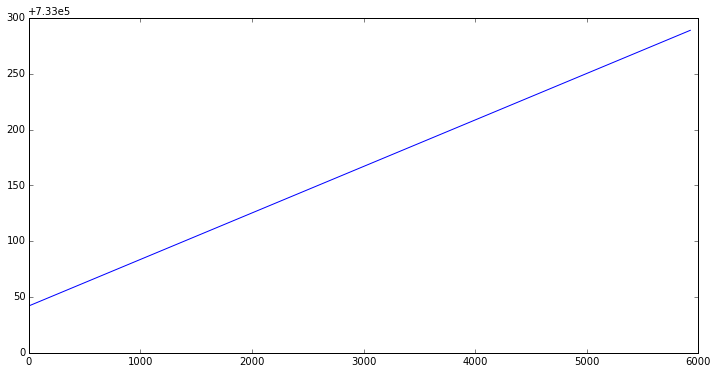

In [76]:
plt.plot(data[:, 0]);

- Dates are monotonously increasing, as it should be
- No jump discernible for winter/summer-time transition: fixed time throughout the year

#### Some data exploration

- We extract the individual columns for easier access

In [77]:
t, lt, ltmin, ltmax, j2, j5, j10, j20, j50, j100, grmin = np.hsplit(data, 11)

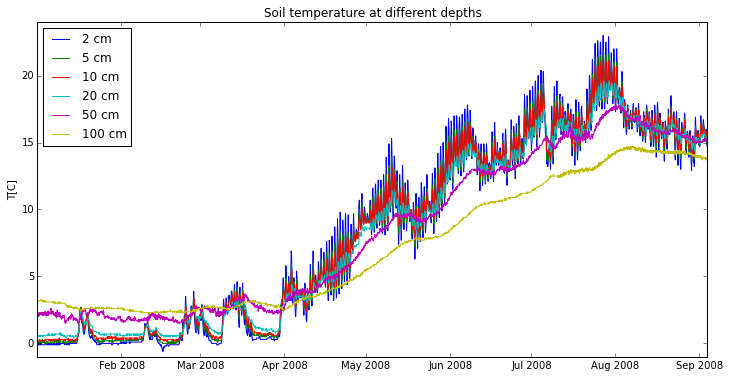

In [78]:
plt.plot_date(t, j2, '-', label='2 cm')
plt.plot_date(t, j5, '-', label='5 cm')
plt.plot_date(t, j10, '-', label='10 cm')
plt.plot_date(t, j20, '-', label='20 cm')
plt.plot_date(t, j50, '-', label='50 cm')
plt.plot_date(t, j100, '-', label='100 cm')
plt.legend(loc='upper left')
plt.ylabel('T[C]')
plt.ylim(-1, 24)
plt.title('Soil temperature at different depths');

## 6. A very brief introduction to Pandas

- [Pandas: Python Data Analysis Library](http://pandas.pydata.org)
- Very powerful tool to handle large datasets
- Excellent at handling missing data
- Support similar concepts as R (dataframes)
- Textbook: [Wes McKinney: Python for Data Analysis](http://shop.oreilly.com/product/0636920023784.do)
- See the [10 minute intro video](http://vimeo.com/59324550) for an introduction

### Loading data with Pandas

In [79]:
import pandas as pd

- Pandas solves a lot of the issues we had on importing for us
    - decimal separator
    - day-month-order in dates
- We just need to tell it explicitly to parse the dates into `Datetime` values

In [80]:
pdata = pd.read_csv('Data/TIME2008.csv', sep=';', decimal=',', dayfirst=True, parse_dates=[0])

- We can now look at the data, first just a few lines

In [81]:
pdata.head()

DATO   LT  LTmin  LTmax    RF      LP  NB1   VH  VHmax VR  \
0 2008-01-01 00:10:00 -2.5   -2.5   -2.4  77.4  1021.8    0  4.5    4.8  N   
1 2008-01-01 01:10:00 -2.3   -2.4   -2.2  77.4  1022.1    0  4.2    4.7  N   
2 2008-01-01 02:10:00 -2.2   -2.2   -2.1  77.8  1022.2    0  3.6    4.2  N   
3 2008-01-01 03:10:00 -2.1   -2.1   -2.0  80.5  1022.2    0  4.1    4.4  N   
4 2008-01-01 04:10:00 -1.9   -2.0   -1.8  80.7  1022.3    0  3.6    3.8  N   

   ...    DIFF  UV     Bal  Bl  Gr  R�  Ir  PAR  Alb  GrMin  
0  ...     NaN NaN -182.47 NaN NaN NaN NaN  NaN  NaN  -2.99  
1  ...     NaN NaN -183.05 NaN NaN NaN NaN  NaN  NaN  -2.86  
2  ...     NaN NaN -180.72 NaN NaN NaN NaN  NaN  NaN  -2.74  
3  ...     NaN NaN -180.52 NaN NaN NaN NaN  NaN  NaN  -2.63  
4  ...     NaN NaN -183.08 NaN NaN NaN NaN  NaN  NaN  -2.48  

[5 rows x 28 columns]

- Data has been read
- Column headers have automatically been turned into column names
- We can use those column names as attributes to access the data

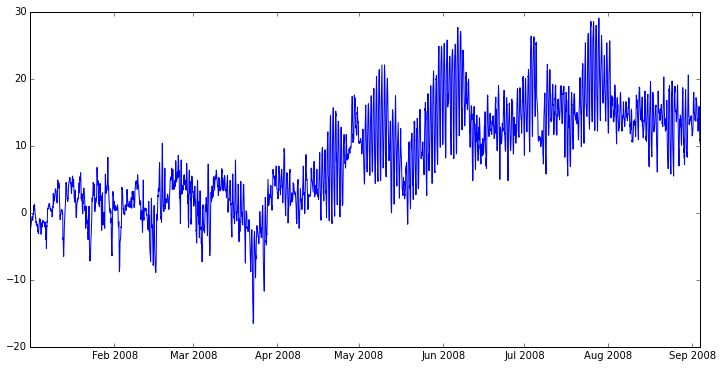

In [82]:
plt.plot(pdata.DATO, pdata.LTmin);

- We can get statistics on the data

In [83]:
pdata.describe()

LT        LTmin        LTmax           RF           LP  \
count  5928.000000  5928.000000  5928.000000  5928.000000  5928.000000   
mean      8.565182     8.216937     8.916616    77.881140   997.398026   
std       7.645376     7.591434     7.708916    20.520317    12.430841   
min     -16.000000   -16.500000   -15.800000    21.300000   954.500000   
25%       2.300000     2.100000     2.600000    62.900000   989.975000   
50%       8.100000     7.700000     8.500000    85.200000   996.000000   
75%      14.500000    14.100000    14.900000    95.600000  1007.000000   
max      29.300000    29.100000    29.400000   100.000000  1033.000000   

               NB1           VH        VHmax        FLUXM          JT2  \
count  5928.000000  5928.000000  5928.000000  5928.000000  5928.000000   
mean      0.139103     2.616380     3.172908    -3.102244     8.461505   
std       0.617887     1.678487     1.833669    15.093608     7.037998   
min       0.000000     0.100000     0.200000   -82.300000    -0.600000   
25%       0.000000     1.300000     1.800000    -5.900000     0.600000   
50%       0.000000     2.300000     2.900000    -1.500000     8.950000   
75%       0.000000     3.600000     4.300000     4.000000    15.300000   
max      16.800000     9.900000    10.900000    37.300000    23.000000   

          ...              DIFF           UV          Bal           Bl  \
count     ...       3169.000000  2910.000000  5928.000000  2819.000000   
mean      ...         95.372938     5.236601     9.618023    15.670529   
std       ...         71.249916     1.563005   134.390101     3.571531   
min       ...          3.800000    -8.930000  -781.500000    -5.380000   
25%       ...         39.070000     4.250000   -25.832500    14.780000   
50%       ...         75.450000     4.870000    -4.670000    15.440000   
75%       ...        135.280000     5.930000    33.630000    16.230000   
max       ...        390.380000    20.410000   553.280000   104.840000   

                Gr           R�           Ir          PAR          Alb  \
count  2854.000000  2854.000000  2969.000000  3196.000000  1763.000000   
mean     20.837232     8.722260    49.656666   575.780569     0.235400   
std      16.456564     1.812553     3.927785   490.076667     0.035481   
min    -852.050000   -13.120000    21.630000 -1069.170000     0.080000   
25%      20.420000     8.200000    48.070000   156.510000     0.220000   
50%      21.150000     8.650000    50.210000   421.505000     0.230000   
75%      21.927500     9.120000    51.510000   926.405000     0.250000   
max      39.580000    40.540000    65.270000  1890.000000     0.470000   

             GrMin  
count  5928.000000  
mean      8.335403  
std      11.107717  
min     -25.210000  
25%       0.400000  
50%       6.285000  
75%      14.770000  
max      50.140000  

[8 rows x 26 columns]

- And we can do fancy statistical plots

/Users/plesser/anaconda/lib/python2.7/site-packages/pandas/tools/plotting.py:2633: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  warnings.warn(msg, FutureWarning)


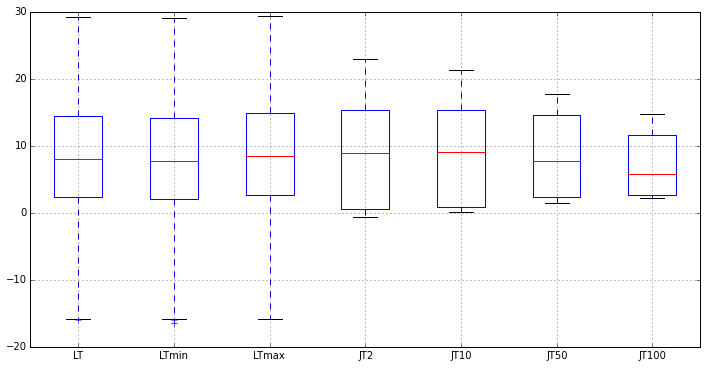

In [84]:
pdata.boxplot(column=['LT', 'LTmin', 'LTmax', 'JT2', 'JT10', 'JT50', 'JT100']);

## 7.  An even shorter introduction to SymPy

- [SymPy](http://www.sympy.org/en/index.html) provides *computer algebra* in Python
- It allows you to perform *symbolic* manipulations on mathematical expressions (instead of *numerical* calculations)
- Examples based on SymPy documentation

In [85]:
from sympy import *
init_printing(use_latex=True)

### Find the derivative of an expression

$$\frac{d}{dx} \sin(x) e^x$$

In [86]:
x = symbols('x')
diff(sin(x) * exp(x), x)

### Find the integral of an expression

$$\int e^x\sin x + e^x \cos x dx$$

In [87]:
integrate(exp(x) * sin(x) + exp(x) * cos(x), x)

### Some linear algebra

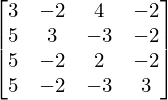

In [88]:
m = Matrix([[3, -2,  4, -2], [5,  3, -3, -2], [5, -2,  2, -2], [5, -2, -3,  3]])
m

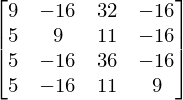

In [89]:
m * m

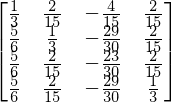

In [90]:
im = m**(-1)
im

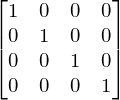

In [91]:
m * im

In [92]:
m.det()

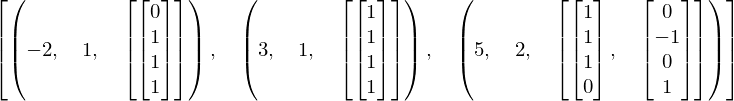

In [93]:
m.eigenvects()

## 8. More cool stuff

- There is a *huge* and constantly growing ecosystem of Python tools for scientific purposes

### Advanced visualizaton tools

- Many of these build on Matplotlib
    - [Seaborn: Statistical Data Visualization](http://stanford.edu/~mwaskom/software/seaborn/)
    - [HoloViews: Composable, declarative data structures for building even complex visualizations easily](http://holoviews.org)
    - [Glue: Multidimensional data exploration](http://www.glueviz.org/en/stable/)
    - [MayaVi: 3D scientific data visualization and plotting in Python](http://docs.enthought.com/mayavi/mayavi/)
    - [Plotly: Commercial visualization tool](https://plot.ly)

### "Real world" data analysis

- [Processing the UK's real-time traffic data with Python](http://rjw57.github.io/blog/2013/06/19/real-time-traffic-data/)
    - Detailed tutorial on how to use publicly available traffic data to visualize traffic
    - Also available as [IPython Notebook](http://rjw57.github.io/blog/static/notebooks/realtime-traffic-data.ipynb)
        - Requires UK map [available here](https://gist.github.com/rjw57/5805059)
    - Similar data available for Norway from [Statens Vegvesen](http://www.vegvesen.no/data), unfortunately rather more difficult to access for beaurocratic reasons 

### Modeling PV systems

- [Sandia National Laboratory's PVLib](http://pvlib-python.readthedocs.org/en/latest/index.html)
- [Example IPython Notebook](http://nbviewer.ipython.org/github/pvlib/pvsc2015/blob/master/paper.ipynb)